# **In-Class Assignment: Text Classification**

## *IS 5150*
## Name: Key

In this in-class assignment we will be working with the `20 NewsGroup` dataset which is available through `sklearn`. This dataset contains approximately 18,000 newsgroup posts across 20 different categories/topics.

We will use various methods of feature extraction and engineering, as well as several different classification algorithms in order to develop the best performing classifier.

Preprocessing and normalization will proceed in the typical fashion, however, we will also consider what additional information should be stripped from each document in order to prevent data leakage, a new consideration now that we're getting into text mining! Finally, certain documents which are empty will be removed from the corpus as an additional corpus cleaning step.

Let's begin as always be importing our dependencies...

In [2]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter

%matplotlib inline

## **1) Setting up the corpus: 20 NewsGroups**

Here we are going to set the `remove` parameter to strip all documents of `headers`, `footers`, and `quotes`. Why sort of information is typically contained in these sections, and why would we want to remove them before training our text classification model?

In [ ]:
data = fetch_20newsgroups(subset='all', shuffle=True,
                          remove=('headers', 'footers', 'quotes'))

data_labels_map = dict(enumerate(data.target_names))

> #### **A) Build a dataframe to view the corpus containing the article text, target label value, and the target label:**

In [ ]:
corpus, target_labels, target_names = (data.data, data.target, 
                                       [data_labels_map[label] for label in data.target])
data_df = pd.DataFrame({'Article': corpus, 'Target Label': target_labels, 'Target Name': target_names})
print(data_df.shape)
data_df.head(10)

(18846, 3)


,Article,Target Label,Target Name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc


> #### **B) Preprocessing & Normalization**
> Apart from the steps we have been covering in the semester so far regarding cleaning text specifically, what are some other steps we should take to ensure data quality that are not text specific (e.g., what should you check for in any dataset?)

**Should check for missing data and duplicates!**

In [ ]:
total_nulls = data_df[data_df.Article.str.strip() == ''].shape[0]                              # find the number of documents that are completely blank (i.e, contain only blank spaces)
print("Empty documents:", total_nulls)

Empty documents: 515


In [ ]:
data_df = data_df[~(data_df.Article.str.strip() == '')]                                        # drop rows where Article is completely blank
data_df.shape

(18331, 3)

In [ ]:
duplicate = data_df[data_df.duplicated()]                                                      # check for duplicated rows
print("Duplicate Rows :", len(duplicate))

Duplicate Rows : 47


In [ ]:
data_df = data_df.drop_duplicates()                                                            # drop duplicated rows
data_df.shape 

(18284, 3)

> #### **Normalize the corpus...we'll bring in a function that combines a lot of the preprocessing we've done before...**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

from pprint import pprint
import numpy as np
import re
from bs4 import BeautifulSoup

import spacy
nlp = spacy.load('en_core_web_sm')                                                                                            # dependencies

import unicodedata

!pip install contractions
import contractions

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]                                                                         # html parsing
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def tokenize_text(text):                                                                                                      # text tokenization
    sentences = nltk.sent_tokenize(text)
    word_tokens = [nltk.word_tokenize(sentence) for sentence in sentences] 
    return word_tokens

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')                            # accent removal
    return text

def expand_contractions(text):                                                                                                # expand contractions
    expanded_words = []
    for word in text.split():
        expanded_words.append(contractions.fix(word))
        expanded_text = ' '.join(expanded_words)
    return expanded_text

def remove_special_characters(text, remove_digits=False):                                                                    # special character removal
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def simple_stemmer(text):                                                                                                   # stemmer
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)                                                                                                        # lemmatizer
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False, stopwords=stopword_list):                                                   # stopword removal
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,                                                # define normalize corpus function
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [ ]:
norm_corpus = normalize_corpus(corpus=data_df['Article'])                                                       # let's make sure we're using a GPU instance here...took about 11 minutes to run
data_df['Clean Article'] = norm_corpus

In [ ]:
!pip install xlsxwriter

In [ ]:
df = data_df.applymap(lambda x: x.encode('unicode_escape').
                 decode('utf-8') if isinstance(x, str) else x)

In [ ]:
df.to_excel("Cleaned_news20.xlsx")

> #### **Read in Cleaned Excel file**

In [3]:
df = pd.read_excel("/content/Cleaned_news20.xlsx")
df.head()

,Target Label,Target Name,Article,Clean Article
0,10,rec.sport.hockey,\n\nI am sure some bashers of Pens fans are pr...,I sure basher pen fan pretty confused lack kin...
1,3,comp.sys.ibm.pc.hardware,My brother is in the market for a high-perform...,brother market high performance video card sup...
2,17,talk.politics.mideast,\n\n\n\n\tFinally you said what you dream abou...,finally say dream mediterranean new area great...
3,3,comp.sys.ibm.pc.hardware,\nThink!\n\nIt's the SCSI card doing the DMA t...,think scsi card dma transfer disk scsi card dm...
4,4,comp.sys.mac.hardware,1) I have an old Jasmine drive which I cann...,I old jasmine drive I use new system understan...


> #### **Do one more check to make sure we don't have any blank documents now that we cleaned the text...**

In [4]:
df = df.replace(r'^(\s?)+$', np.nan, regex=True)            # replace blank entries with nans
df.info()                                                   # pull up df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18284 entries, 0 to 18283
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Target Label   18284 non-null  int64 
 1   Target Name    18284 non-null  object
 2   Article        18284 non-null  object
 3   Clean Article  18261 non-null  object
dtypes: int64(1), object(3)
memory usage: 571.5+ KB


**We can see that we have some missing data in our Clean Article column (less than 18284); so let's drop those nulls out.**

In [5]:
df = df.dropna().reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18261 entries, 0 to 18260
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Target Label   18261 non-null  int64 
 1   Target Name    18261 non-null  object
 2   Article        18261 non-null  object
 3   Clean Article  18261 non-null  object
dtypes: int64(1), object(3)
memory usage: 570.8+ KB


## **2) Building Train and Test Sets**

Our next step in developing a text classification model is to divide out our data into a training and test set. We'll use 66% of our data to train, and the remaining third as a test set.

In [6]:
train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names =\
                                 train_test_split(np.array(df['Clean Article']), np.array(df['Target Label']),
                                                       np.array(df['Target Name']), test_size=0.33, random_state=42)

train_corpus.shape, test_corpus.shape

((12234,), (6027,))

**Let's examine the distribution of news article categories across the training and test sets**

In [7]:
trd = dict(Counter(train_label_names))                                                      # create training dictionary of labels
tsd = dict(Counter(test_label_names))                                                       # create test set dictionary of labels

(pd.DataFrame([[key, trd[key], tsd[key]] for key in trd],                                   # display as dataframe
             columns=['Target Label', 'Train Count', 'Test Count'])
.sort_values(by=['Train Count', 'Test Count'],
             ascending=False))

,Target Label,Train Count,Test Count
13,rec.sport.hockey,670,304
15,comp.windows.x,667,297
8,rec.motorcycles,657,310
9,sci.crypt,651,311
17,comp.os.ms-windows.misc,647,296
14,soc.religion.christian,645,329
11,sci.electronics,639,316
18,comp.sys.ibm.pc.hardware,637,325
3,comp.sys.mac.hardware,637,289
12,sci.med,632,326


**Are the distributions of each category between the training and the test set roughly what you'd expect given a 66-33 split on the data? Which category has the most observations, which has the least?**

Yes, all have roughly the same ratio of observations between the training to test set/roughly the same distribution of categories amongst the training and test set. Rec.sport.hockey has the greatest number of observations, ralk.religion.misc has the least -- though there isn't a huge class imbalance.

## **3) Classification with Bag of Words Features**
> #### **Feature Engineering using Bag of Words Modeling**

In [8]:
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0)                        # set parameters of BoW 
cv_train_features = cv.fit_transform(train_corpus)                                # fit model to training corpus, build BOW features on train articles

In [9]:
cv_test_features = cv.transform(test_corpus)                                      # transform test articles to BOW features

> #### **Fit Classifiers to BoW Features; Evaluate 5-fold Cross-Validated Accuracy**

**Naive Multinomial Bayes**

In [10]:
from sklearn.naive_bayes import MultinomialNB

In [11]:
mnb = MultinomialNB(alpha=1)                                                              # set model parameters
mnb.fit(cv_train_features, train_label_names)                                             # fit model to training data features & labels (x,y)

mnb_bow_cv_scores = cross_val_score(mnb, cv_train_features, train_label_names, cv=5)      # run 5-fold cross-validation
mnb_bow_cv_mean_score = np.mean(mnb_bow_cv_scores)                                        # compute average cross-validated accuracy

print('CV Accuracy (5-fold):', mnb_bow_cv_scores)                                         # print 5-fold accuracy
print('Mean CV Accuracy:', mnb_bow_cv_mean_score)                                         # print average accuracy

mnb_bow_test_score = mnb.score(cv_test_features, test_label_names)                        # calculate test set accuracy
print('Test Accuracy:', mnb_bow_test_score)                                               # print test set accuracy

CV Accuracy (5-fold): [0.67919902 0.67061708 0.67674704 0.68532897 0.66557645]
Mean CV Accuracy: 0.6754937128280628
Test Accuracy: 0.6943753111000498


**Not great, but let's establish our baseline based on our majority class. How can we calculate that?**

Total observations of majority class divided by all observations

In [ ]:
print("Basline Accuracy = ", (670+304)/len(df))

Basline Accuracy =  0.05333771425442199


**Logistic Regression** -- took about 3 minutes to run using regular runtime; consider switching to GPU instance

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)                     # set model parameters
lr.fit(cv_train_features, train_label_names)                                                  # fit model to training data features & labels (x,y)

lr_bow_cv_scores = cross_val_score(lr, cv_train_features, train_label_names, cv=5)            # run 5-fold cross-validation
lr_bow_cv_mean_score = np.mean(lr_bow_cv_scores)                                              # compute average cross-validated accuracy

print('CV Accuracy (5-fold):', lr_bow_cv_scores)                                              # print 5-fold accuracy
print('Mean CV Accuracy:', lr_bow_cv_mean_score)                                              # print avg accuracy


lr_bow_test_score = lr.score(cv_test_features, test_label_names)                              # compute test set accuracy
print('Test Accuracy:', lr_bow_test_score)                                                    # print test set accuracy

CV Accuracy (5-fold): [0.70126686 0.67020842 0.69718022 0.67184307 0.66721177]
Mean CV Accuracy: 0.6815420688005169
Test Accuracy: 0.6898954703832753


**Was there a considerable difference in performance, yes or no? In your opinion, does the difference in performance outweigh the difference in training time?**

**Support Vector Machines**

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
svm = LinearSVC(penalty='l2', C=1, random_state=42)                                                   # set model parameters
svm.fit(cv_train_features, train_label_names)                                                         # fit model to training features and labels (x,y)

svm_bow_cv_scores = cross_val_score(svm, cv_train_features, train_label_names, cv=5)                  # run 5-fold cross-validation
svm_bow_cv_mean_score = np.mean(svm_bow_cv_scores)                                                    # compute average cross-validated accuracy

print('CV Accuracy (5-fold):', svm_bow_cv_scores)                                                     # print 5-fold accuracy
print('Mean CV Accuracy:', svm_bow_cv_mean_score)                                                     # print avg accuracy

svm_bow_test_score = svm.score(cv_test_features, test_label_names)                                    # compute test set accuracy
print('Test Accuracy:', svm_bow_test_score)                                                           # print test set accuracy

CV Accuracy (5-fold): [0.6546792  0.64609726 0.66693911 0.6411933  0.64022895]
Mean CV Accuracy: 0.649827562643663
Test Accuracy: 0.6537249045959848


**The SVM trained considerably faster than the logistic regression; how does tha accuracy compare?**

**Random Forest Classifier** - took about 30 seconds to train

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)                                   # set model parameters
rfc.fit(cv_train_features, train_label_names)                                                    # fit model to training features and labels (x,y)

rfc_bow_cv_scores = cross_val_score(rfc, cv_train_features, train_label_names, cv=5)             # run 5-fold cross-validation
rfc_bow_cv_mean_score = np.mean(rfc_bow_cv_scores)                                               # compute average cross-validated accuracy

print('CV Accuracy (5-fold):', rfc_bow_cv_scores)                                                # print 5-fold accuracy
print('Mean CV Accuracy:', rfc_bow_cv_mean_score)                                                # print avg accuracy

rfc_bow_test_score = rfc.score(cv_test_features, test_label_names)                               # compute test set accuracy
print('Test Accuracy:', rfc_bow_test_score)                                                      # print test set accuracy

CV Accuracy (5-fold): [0.53780139 0.51246424 0.52881079 0.53126277 0.49632052]
Mean CV Accuracy: 0.5213319428298573
Test Accuracy: 0.5314418450306952


**Gradient Boosting Machines** -- Took ~10 minutes to run

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(cv_train_features, train_label_names)

gbc_bow_cv_scores = cross_val_score(gbc, cv_train_features, train_label_names, cv=5)
gbc_bow_cv_mean_score = np.mean(gbc_bow_cv_scores)

print('CV Accuracy (5-fold):', gbc_bow_cv_scores)
print('Mean CV Accuracy:', gbc_bow_cv_mean_score)

gbc_bow_test_score = gbc.score(cv_test_features, test_label_names)
print('Test Accuracy:', gbc_bow_test_score)

CV Accuracy (5-fold): [0.55537393 0.53943604 0.5500613  0.57335513 0.54415372]
Mean CV Accuracy: 0.552476024006568
Test Accuracy: 0.549195287871246


**Which of the models had the best performance in correctly classifying article labels; which had the worst? Let's display the test set accuracies for each model in a table below:**

In [ ]:
models = gbc_bow_test_score, rfc_bow_test_score, svm_bow_test_score, lr_bow_test_score, mnb_bow_test_score

pd.DataFrame(data = models,
             index = ["GBC", "RFC", "SVM", "LR", "MNB"],
             columns = ["Test Set Accuracy"])

,Test Set Accuracy
GBC,0.549195
RFC,0.531442
SVM,0.653725
LR,0.689895
MNB,0.694375


## **4) TF-IDF Feature Weights**

Clearly none of the models achieved great performance in classifying the topics/categories of the news articles; but remember, BoW models produce very sparse representations of 0s and 1s best on term frequencies within and amongst documents. We can try to construct more representative vectors by weighting words by their term frequency-inverse document frequency. Let's implement it and then retrain our models.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)                                    # set parameters of Tfidf Vectorizer
tv_train_features = tv.fit_transform(train_corpus)                                            # fit to training corpus to produce tfidf weights

In [ ]:
tv_test_features = tv.transform(test_corpus)                                                  # transform test articles into features

**Mutlinomial Naive Bayes**

In [ ]:
mnb = MultinomialNB(alpha=1)                                                                # set model parameters
mnb.fit(tv_train_features, train_label_names)                                               # fit model to training data features & labels (x,y)

mnb_tfidf_cv_scores = cross_val_score(mnb, tv_train_features, train_label_names, cv=5)      # run 5-fold cross-validation
mnb_tfidf_cv_mean_score = np.mean(mnb_tfidf_cv_scores)                                      # compute average cross-validated accuracy

print('CV Accuracy (5-fold):', mnb_tfidf_cv_scores)                                         # print 5-fold accuracy
print('Mean CV Accuracy:', mnb_tfidf_cv_mean_score)                                         # print average accuracy

mnb_tfidf_test_score = mnb.score(tv_test_features, test_label_names)                        # calculate test set accuracy
print('Test Accuracy:', mnb_tfidf_test_score) 

CV Accuracy (5-fold): [0.72456069 0.71148345 0.72496935 0.72496935 0.71136549]
Mean CV Accuracy: 0.7194696661622138
Test Accuracy: 0.7237431557989049


**Logistic Regression**

In [ ]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42, n_jobs=-1)                          # set n_jobs to -1 to run all CPUs in parallel
lr.fit(tv_train_features, train_label_names)

lr_tfidf_cv_scores = cross_val_score(lr, tv_train_features, train_label_names, cv=5, n_jobs=-1)
lr_tfidf_cv_mean_score = np.mean(lr_tfidf_cv_scores)

print('CV Accuracy (5-fold):', lr_tfidf_cv_scores)
print('Mean CV Accuracy:', lr_tfidf_cv_mean_score)

lr_tfidf_test_score = lr.score(tv_test_features, test_label_names)
print('Test Accuracy:', lr_tfidf_test_score)

CV Accuracy (5-fold): [0.75112383 0.74008991 0.74826318 0.74744585 0.73916599]
Mean CV Accuracy: 0.7452177495697001
Test Accuracy: 0.7469719595155135


**Support Vector Machines**

In [ ]:
svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(tv_train_features, train_label_names)

svm_tfidf_cv_scores = cross_val_score(svm, tv_train_features, train_label_names, cv=5)
svm_tfidf_cv_mean_score = np.mean(svm_tfidf_cv_scores)

print('CV Accuracy (5-fold):', svm_tfidf_cv_scores)
print('Mean CV Accuracy:', svm_tfidf_cv_mean_score)

svm_tfidf_test_score = svm.score(tv_test_features, test_label_names)
print('Test Accuracy:', svm_tfidf_test_score)

CV Accuracy (5-fold): [0.76910503 0.74948917 0.76011443 0.76665304 0.75143091]
Mean CV Accuracy: 0.759358514990405
Test Accuracy: 0.7638958022233283


**Random Forest Classifier**

In [ ]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(tv_train_features, train_label_names)

rfc_tfidf_cv_scores = cross_val_score(rfc, tv_train_features, train_label_names, cv=5)
rfc_tfidf_cv_mean_score = np.mean(rfc_tfidf_cv_scores)

print('CV Accuracy (5-fold):', rfc_tfidf_cv_scores)
print('Mean CV Accuracy:', rfc_tfidf_cv_mean_score)

rfc_tfidf_test_score = rfc.score(tv_test_features, test_label_names)
print('Test Accuracy:', rfc_tfidf_test_score)

CV Accuracy (5-fold): [0.5230895  0.53984471 0.53902738 0.545566   0.52044154]
Mean CV Accuracy: 0.5335938244002619
Test Accuracy: 0.536917205906753


**Gradient Boosting Classifier** -- run outside of class because this guy is real slow to train (took 10 min)

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(tv_train_features, train_label_names)

gbc_tfidf_cv_scores = cross_val_score(gbc, tv_train_features, train_label_names, cv=5)
gbc_tfidf_cv_mean_score = np.mean(gbc_tfidf_cv_scores)

print('CV Accuracy (5-fold):', gbc_tfidf_cv_scores)
print('Mean CV Accuracy:', gbc_tfidf_cv_mean_score)

gbc_tfidf_test_score = gbc.score(tv_test_features, test_label_names)
print('Test Accuracy:', gbc_tfidf_test_score)

CV Accuracy (5-fold): [0.56272987 0.53248876 0.55864324 0.56967716 0.54292723]
Mean CV Accuracy: 0.5532932511016042
Test Accuracy: 0.5437199269951883


**Overall, did you see an improvement in classifier performance using the TF-IDF feature vectors over the basic bag of words feature vectors?**

Let's display our model results in another dataframe, but we'll add a bit more detail this time and display the CV and Test scores for both the Bag of Words term frequencies (TF) and TF-IDF.

In [ ]:
pd.DataFrame([['Naive Bayes', mnb_bow_cv_mean_score, mnb_bow_test_score, 
               mnb_tfidf_cv_mean_score, mnb_tfidf_test_score],
              ['Logistic Regression', lr_bow_cv_mean_score, lr_bow_test_score, 
               lr_tfidf_cv_mean_score, lr_tfidf_test_score],
              ['Linear SVM', svm_bow_cv_mean_score, svm_bow_test_score, 
               svm_tfidf_cv_mean_score, svm_tfidf_test_score],
              ['Random Forest', rfc_bow_cv_mean_score, rfc_bow_test_score, 
               rfc_tfidf_cv_mean_score, rfc_tfidf_test_score],
              ['Gradient Boosted Machines', gbc_bow_cv_mean_score, gbc_bow_test_score, 
               gbc_tfidf_cv_mean_score, gbc_tfidf_test_score]],
             columns=['Model', 'CV Score (TF)', 'Test Score (TF)', 'CV Score (TF-IDF)', 'Test Score (TF-IDF)'],
             ).T

,0,1,2,3,4
Model,Naive Bayes,Logistic Regression,Linear SVM,Random Forest,Gradient Boosted Machines
CV Score (TF),0.675494,0.681542,0.649828,0.521332,0.552476
Test Score (TF),0.694375,0.689895,0.653725,0.531442,0.549195
CV Score (TF-IDF),0.71947,0.745218,0.759359,0.533594,0.553293
Test Score (TF-IDF),0.723743,0.746972,0.763896,0.536917,0.54372


**Which model and method of feature engineering produced the highest test set and CV accuracies?**

Linear SVM

## **5) Word Embeddings with GloVe** 

We've tried two more traditional approaches for vectorizing our corpus; now let's try a more modern method and utilize some pretrained GloVe embeddings to represent our documents in vector space, to see if we can further improve document classification accuracy...

In [ ]:
!pip install spacy

try: 
  spacy.load('en_core_web_lg')
except:
  !python -m spacy download en_core_web_lg   

import spacy
nlp = spacy.load('en_core_web_lg')                                                                      # get spacy installed, imported and load glove embeddings model

*Took about 4 minutes to produce word embeddings for training and test set*

In [ ]:
train_nlp = [nlp(item) for item in train_corpus]                                                        # fit glove embeddings model to training set
train_glove_features = np.array([item.vector for item in train_nlp])                                    # assign training features to array

test_nlp = [nlp(item) for item in test_corpus]                                                          # fit glove embeddings model to test set
test_glove_features = np.array([item.vector for item in test_nlp])                                      # assign test geatures to array

**Now let's retrain the Linear SVM (best performing) with the GloVe Embeddings to see if the accuracy improves:**

In [ ]:
svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(train_glove_features, train_label_names)

svm_glove_cv_scores = cross_val_score(svm, train_glove_features, train_label_names, cv=5)
svm_glove_cv_mean_score = np.mean(svm_glove_cv_scores)

print('CV Accuracy (5-fold):', svm_glove_cv_scores)
print('Mean CV Accuracy:', svm_glove_cv_mean_score)

svm_glove_test_score = svm.score(test_glove_features, test_label_names)
print('Test Accuracy:', svm_glove_test_score)

CV Accuracy (5-fold): [0.58684103 0.56763384 0.6040049  0.6040049  0.56173344]
Mean CV Accuracy: 0.5848436234934495
Test Accuracy: 0.5591504894640783


**Did accuracy improve using word embeddings? Yes or No? Is this surprising?**

Accuracy actually decreased using word embeddings; this is perhaps initally surprising but sometimes traditional methods will outperform more modern methods. Increasing complexity of the word/document representations is not a guarantee better results every time -- so it's good to keep in mind that we don't always have to hit every problem with our biggest hammer.

## **6) Model Tuning**

Let's take our best performing model with TF-IDF features and perform some tuning. We can do this automatically using cross-validation grid searching to compare different parameters impact on cross-validated accuracy.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('svm', LinearSVC(random_state=42))                                                 # set pipeline to use tf-idf features with SVM model
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],                                                       # set parameter value range for grid to search
              'svm__C': [0.01, 0.1, 1, 5]
}

gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, verbose=2)                                            # set parameters of cross-validated grid search
gs_svm = gs_svm.fit(train_corpus, train_label_names)                                                        # fit on training data

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   1.5s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   1.4s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   1.5s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   1.4s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   1.3s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   6.0s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   6.7s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   5.6s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   5.5s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   6.1s
[CV] END ..............svm__C=0.1, tfidf__ngram_range=(1, 1); total time=   1.3s
[CV] END ..............svm__C=0.1, tfidf__ngram_r

**If we want to see the parameters of the best performing models**

In [ ]:
gs_svm.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('svm', LinearSVC(C=5, random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'svm': LinearSVC(C=5, random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'svm__C': 5,
 'svm__class_weight': None,
 'svm__dual': True,
 'svm__fit_intercept': True,
 'svm__intercept_scaling': 1,
 'svm__loss': 'squared_hinge',
 'svm__max_iter'

**Let's check out that test set accuracy to see our best performing model's accuracy. How much of a lift did we get from grid searching?**

In [ ]:
best_svm_test_score = gs_svm.score(test_corpus, test_label_names)
print('Test Accuracy :', best_svm_test_score)

Test Accuracy : 0.783142525302804


About a 2% bump in accuracy which is pretty substantial!

## **7) Model Performance Evaluation**

For our final step, let's examine some other metrics of classification performance: precision, recall, and f1-score. Remember, accuracy isn't the only metric that matters, and it doesn't tell the whole story. We can examine the precision, recall, and f-1 for each individual class to see which categories were most accurately predicted!

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics

In [ ]:
def get_metrics(true_labels, predicted_labels): 
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))

def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 

In [ ]:
svm_predictions = gs_svm.predict(test_corpus)
unique_classes = list(set(test_label_names))

get_metrics(test_label_names, svm_predictions)

Accuracy: 0.7831
Precision: 0.7812
Recall: 0.7831
F1 Score: 0.7811


In [ ]:
display_classification_report(test_label_names, svm_predictions, classes = unique_classes)

                          precision    recall  f1-score   support

            misc.forsale       0.76      0.79      0.78       314
               rec.autos       0.74      0.81      0.78       306
comp.sys.ibm.pc.hardware       0.71      0.71      0.71       325
         rec.motorcycles       0.78      0.78      0.78       310
           comp.graphics       0.77      0.73      0.75       336
               sci.space       0.85      0.84      0.84       324
   comp.sys.mac.hardware       0.75      0.79      0.77       289
               sci.crypt       0.87      0.84      0.85       311
      talk.politics.misc       0.73      0.70      0.72       252
   talk.politics.mideast       0.87      0.83      0.85       318
 comp.os.ms-windows.misc       0.74      0.74      0.74       296
      talk.religion.misc       0.58      0.40      0.47       188
                 sci.med       0.83      0.84      0.84       326
         sci.electronics       0.73      0.75      0.74       316
        r

**Let's make the assumption that there's roughly equal cost to false positives or negatives for any given class; but we have uneven class distribution. What is the metric we should care most about then amongst accuracy, recall, precision, and f1-score?**

F-1 score

**With that in mind, which class did the model best predict, and which did it worst predict?**

Best = Hockey


Worst = Miscellanious Religion, followed by Atheism

Perhaps the model is confusing these two labels/topics

**Let's produce a confusion matrix to examine where the model was making mistakes...**

In [ ]:
label_data_map = {v:k for k, v in data_labels_map.items()}
label_map_df = pd.DataFrame(list(label_data_map.items()), columns=['Label Name', 'Label Number'])
label_map_df

,Label Name,Label Number
0,alt.atheism,0
1,comp.graphics,1
2,comp.os.ms-windows.misc,2
3,comp.sys.ibm.pc.hardware,3
4,comp.sys.mac.hardware,4
5,comp.windows.x,5
6,misc.forsale,6
7,rec.autos,7
8,rec.motorcycles,8
9,rec.sport.baseball,9


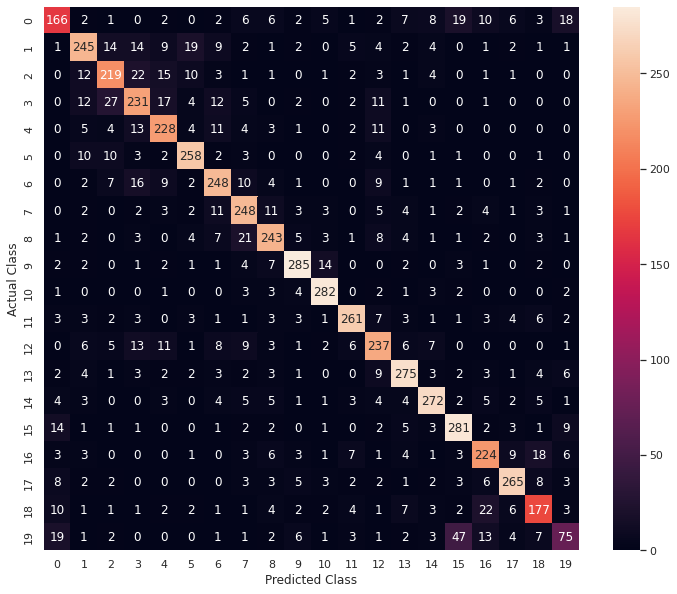

In [ ]:
import seaborn as sns
conf = confusion_matrix(test_label_names, svm_predictions)

sns.heatmap(conf, annot=True, fmt='g')
sns.set(rc={'figure.figsize':(20,20)})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

**Which two categories were most commonly missclassified as one another? Does it make sense that these two categories could be mislabeled as one another, why or why not?**

In [ ]:
label_map_df[label_map_df['Label Number'].isin([15, 19])]

,Label Name,Label Number
15,soc.religion.christian,15
19,talk.religion.misc,19


Religious texts being miscategorized; likely sharing lots of simialr words